In [ ]:
!pip install tensorflow_decision_forests -U -qq
!pip install wurlitzer -U -qq

In [ ]:
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

#Якщо тренувати
#data = pd.read_csv("/content/ResultAllAM15(3).csv", delimiter=';', encoding='utf-8')
#train_df, test_df = train_test_split(data, test_size=0.3, random_state=27)

#Якщо тестувати
train_df = pd.read_csv("/content/ResultAllAM15(3).csv", delimiter=';', encoding='utf-8')
test_df = pd.read_csv("/content/T_var_AM(3).csv", delimiter=';', encoding='utf-8')

# Створення навчального та тестового наборів даних
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="N_Fe", task=model.task)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="N_Fe", task=model.task)

Use /tmp/tmpx7bbrwgr as temporary training directory


In [ ]:
#@title Define "set_cell_height".

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=1)

tuner.choice("num_trees", [430, 400])
tuner.choice("max_depth", [20, 22])
tuner.choice("min_examples", [1, 2])
tuner.choice("num_candidate_attributes_ratio", [0.5, 0.6])

**min_examples**

Коли дерево рішень будується в процесі навчання, воно ухвалює рішення про розбиття вузла на два підвузли на основі значень якоїсь ознаки. Однак розбиття відбувається тільки в тому випадку, якщо кількість прикладів у вузлі більша, ніж min_examples. Збільшення цього значення може призвести до більш стійкого дерева, але з більш грубими розбиттями.

**num_candidate_attributes_ratio**

Якщо значення дорівнює 1.0, то розглядаються всі атрибути. Якщо значення дорівнює 0.8, то розглядається 80% атрибутів, обраних випадковим чином. Це запобігає перенавчанню, оскільки випадковий ліс не буде надто чутливим до конкретних ознак і буде узагальнюватися краще на нові дані.



In [ ]:
%%time
%set_cell_height 300

tuned_model = tfdf.keras.RandomForestModel(tuner=tuner, task=tfdf.keras.Task.REGRESSION)
tuned_model.fit(train_ds, verbose=2)

<IPython.core.display.Javascript object>

Use /tmp/tmp9fwa02hy as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'N_B': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'T': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'd': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Jsc_e': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Eta_e': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'Voc_e': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>}
Label: Tensor("data_6:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'N_B': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'T': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'd': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'Jsc_e': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_3:0' s

[INFO 23-12-05 11:33:36.1909 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 23-12-05 11:33:36.1909 UTC kernel.cc:772] Collect training examples
[INFO 23-12-05 11:33:36.1909 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-12-05 11:33:36.1911 UTC kernel.cc:391] Number of batches: 13
[INFO 23-12-05 11:33:36.1911 UTC kernel.cc:392] Number of examples: 12375
[INFO 23-12-05 11:33:36.1927 UTC kernel.cc:792] Training dataset:
Number of records: 12375
Number of columns: 7

Number of columns by type:
	NUMERICAL: 7 (100%)

Columns:

NUMERICAL: 7 (100%)
	0: "Eta_e" NUMERICAL mean:-4.6901 min:-50.2 max:10.1 sd:9.15644
	1: "Jsc_e" NUMERICAL mean:-3.37471 min:-40.7 max:6.26 sd:7.23624
	2: "N_B" NUMERICAL mean:15.9778

Model trained in 0:00:25.336362
Compiling model...
Model compiled.
CPU times: user 24.6 s, sys: 1.88 s, total: 26.5 s
Wall time: 26.3 s


In [ ]:
# x - вхідні дані, y - цільові дані
# Створює список масивів, по одному для кожної істинної мітки в наборі тестових даних
true_labels = np.concatenate([y.numpy() for x, y in test_ds])
predicted_values = tuned_model.predict(test_ds).flatten()
result_df = pd.DataFrame({"True_Labels": true_labels, "Predicted_Values": predicted_values})
print(result_df)

2/2 [==============================] - 0s 62ms/step
      True_Labels  Predicted_Values
0            10.0         10.059264
1            10.2         10.189029
2            10.3         10.340452
3            10.5         10.511511
4            10.7         10.668263
...           ...               ...
1195         13.3         13.283057
1196         13.5         13.480186
1197         13.7         13.684378
1198         13.8         13.787213
1199         14.0         13.853270

[1200 rows x 2 columns]


In [ ]:
#result_df[['True_Labels', 'Predicted_Values']].to_csv('predicted_vs_true.csv', sep=';', index=False)
result_df[['True_Labels', 'Predicted_Values']].to_excel('predicted_vs_true.xlsx', index=False)

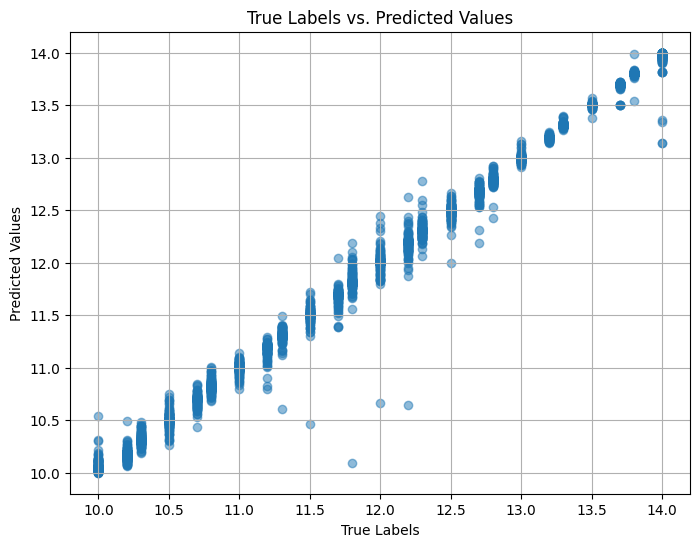

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(result_df["True_Labels"], result_df["Predicted_Values"], alpha=0.5)
plt.title("True Labels vs. Predicted Values")
plt.xlabel("True Labels")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

In [ ]:
# Display the tuning logs.
tuning_logs = tuned_model.make_inspector().tuning_logs()
sorted_logs = tuning_logs.sort_values(by='score', ascending=False)
top_models = sorted_logs.head(5)
display(top_models)

score  evaluation_time   best  num_trees  max_depth  min_examples  \
93 -0.142627      1284.125454   True        510         21             1   
86 -0.142678      1178.204465  False        500         21             1   
98 -0.142692      1353.819881  False        495         21             1   
70 -0.142692       951.763274  False        495         21             1   
33 -0.142693       449.184512  False        520         21             1   

    num_candidate_attributes_ratio  
93                             0.5  
86                             0.6  
98                             0.6  
70                             0.5  
33                             0.5

In [ ]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                              -0.074096
evaluation_time                   631.394415
best                                    True
num_trees                                240
max_depth                                 25
min_examples                               1
num_candidate_attributes_ratio           0.5
Name: 94, dtype: object

In [ ]:
average_rmse = sorted_logs['score'].mean()
print(f"Середнє значення RMSE для всіх моделей: {average_rmse}")

Середнє значення RMSE для всіх моделей: -0.1432599751651287


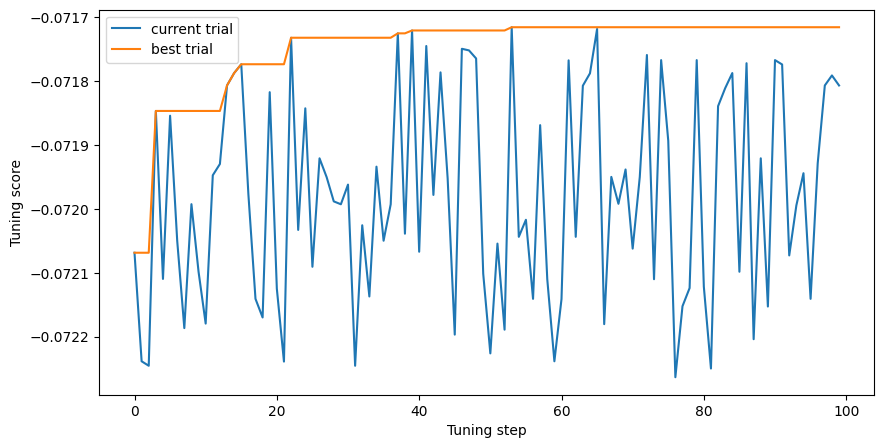

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()